In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [3]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [4]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [5]:
import pandas as pd
df = pd.read_csv("data2.csv")
df.head()

,id,name,date,manner_of_death,armed,age,gender,city,state,signs_of_mental_illness,...,share_hispanic,Race_Asian,Race_Black,Race_Hispanic,Race_Native_American,Race_Other,Race_White,threat_attack,threat_other,threat_undem
0,3,Tim Elliot,2002-01-15,0,1,53.0,1,Shelton,WA,1,...,19.2,1,0,0,0,0,0,1,0,0
1,4,Lewis Lee Lembke,2002-01-15,0,1,47.0,1,Aloha,OR,0,...,21.1,0,0,0,0,0,1,1,0,0
2,890,Phyllis Ilene Jepsen,2002-10-15,0,1,55.0,0,Aloha,OR,1,...,21.1,0,0,0,0,0,1,0,1,0
3,5,John Paul Quintero,2003-01-15,1,0,23.0,1,Wichita,KS,0,...,15.3,0,0,1,0,0,0,0,1,0
4,765,Nicholas Garner,2022-08-15,0,1,26.0,1,Wichita,KS,0,...,15.3,0,0,0,0,0,1,1,0,0


In [6]:
df['Median Income'] = pd.to_numeric(df['Median Income'], errors='coerce')
df = df.dropna()

age_scaled = (df.age - df.age.mean())/df.age.std()
poverty_scaled = (df.poverty_rate - df.poverty_rate.mean())/df.poverty_rate.std()
income_scaled = (df['Median Income']-df['Median Income'].mean())/df['Median Income'].std()
race_scaled = (df.Race_White - df.Race_White.mean())/df.Race_White.std()
df['age'] = age_scaled 
df['poverty_rate'] = poverty_scaled 
df['Median Income'] = income_scaled 
df['Race_White'] = race_scaled 

In [45]:
tmp = df.groupby(['state','city','Median Income','poverty_rate','Race_White'], as_index=False).count()
tmp = tmp.iloc[:,2:6].rename(columns={'id':'ct'})
tmp.head()

,Median Income,poverty_rate,Race_White,ct
0,1.767809,-0.989352,-0.940754,1
1,1.397289,-1.251610,-0.940754,1
2,0.409964,-0.814514,-0.940754,4
3,0.409964,-0.814514,1.062476,1
4,0.109801,-0.602210,-0.940754,1


In [46]:
tmp.loc[tmp.ct>=2, 'high'] = 1
tmp.loc[tmp.ct<2, 'high'] = 0

In [57]:
low_df = df[df['high']==0]
high_df = df[df['high']==1]

In [60]:
high_df.shape

(285, 5)

In [62]:
train_200sample = pd.concat([high_df.sample(n=200, random_state=22),low_df.sample(n=200, random_state=22)])
test_200sample = pd.concat([high_df.sample(n=200, random_state=20),low_df.sample(n=200, random_state=20)])
# train_200sample = df.sample(n=600, random_state = 22)
# test_200sample = df.sample(n=600, random_state = 20)

# shuffle
train_200sample = train_200sample.sample(frac=1)
test_200sample = test_200sample.sample(frac=1)

#the list of predictor variables to be included
var_list = ['poverty_rate','Median Income','Race_White']

train_X = train_200sample[var_list]
train_y = train_200sample['high']

test_X = test_200sample[var_list]
test_y = test_200sample['high']

In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3, 10)
        self.fc2 = nn.Linear(10, 7)
        self.fc3 = nn.Linear(7, 15)
        self.fc4 = nn.Linear(15, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [63]:
from torch.autograd import Variable

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for i in range(len(train_X)):
        item = train_X.iloc[i,:]
        item = item.to_numpy()
        item = np.reshape(item, (-1, len(item)))
        item = Variable(torch.from_numpy(item).float())
        #item = np.array[item]
        #item = item.double()
        
        label = torch.tensor(np.array([train_y.iloc[i]]))
        #label = torch.FloatTensor(one_hot_encoding(label)).view(1, -1)
        label = label.float()
        label = label.type(torch.LongTensor)
        #print(label)
        
        optimizer.zero_grad()
        # Forward pass
        output = model(item)
        # Calculating loss
        loss = loss_func(output, label)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-4-625640256c98>:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [10%]	Loss: -0.4977
Training [20%]	Loss: -0.5029
Training [30%]	Loss: -0.4996
Training [40%]	Loss: -0.4941
Training [50%]	Loss: -0.5002
Training [60%]	Loss: -0.5016
Training [70%]	Loss: -0.4999
Training [80%]	Loss: -0.4976
Training [90%]	Loss: -0.4971
Training [100%]	Loss: -0.5016


Text(0, 0.5, 'Neg Log Likelihood Loss')

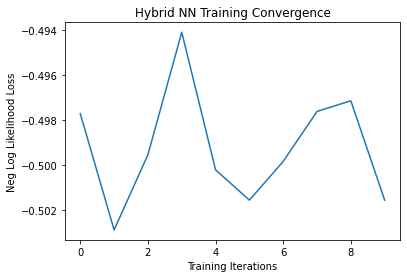

In [64]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [65]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for i in range(len(test_X)):
        item = test_X.iloc[i,:]
        item = item.to_numpy()
        item = np.reshape(item, (-1, len(item)))
        item = Variable(torch.from_numpy(item).float())
        output = model(item)
        
        label = torch.tensor(np.array([test_y.iloc[i]]))
        label = label.float()
        label = label.type(torch.LongTensor)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(label.view_as(pred)).sum().item()
        
        loss = loss_func(output, label)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_X) * 100)
        )

Performance on test data:
	Loss: -0.5009
	Accuracy: 50.0%


In [56]:
df.high.mean()

0.20444763271162122

In [55]:
df.head()

,Median Income,poverty_rate,Race_White,ct,high
0,1.767809,-0.989352,-0.940754,1,0.0
1,1.397289,-1.251610,-0.940754,1,0.0
2,0.409964,-0.814514,-0.940754,4,1.0
3,0.409964,-0.814514,1.062476,1,0.0
4,0.109801,-0.602210,-0.940754,1,0.0
